# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# Define the folder with masks
folder = "/content/drive/MyDrive/DL/Dataset/morocco_masks"

# Get the list of all files in the folder
mask_files = [f for f in os.listdir(folder) if f.endswith('.png')]

# Sort the files based on the date (assuming the filenames are of the format "YYYY-MM-DD.png")
mask_files.sort(key=lambda x: (x.split('_')[0], x.split('_')[1], x.split('_')[2]))

In [ ]:
# Map pixel values to class labels
pixel_to_class = {0: 0, 70: 1, 162: 2, 213: 3}

# Function to map pixel values to class indices
def map_pixel_to_class(image):
    img_array = np.array(image)
    # Apply the mapping to the entire image array
    return np.vectorize(lambda x: pixel_to_class.get(x, 0))(img_array)

In [ ]:
# Resize the images for memory compatibility (let's use 256x256 for input)
resize_size = (256, 256)

# Prepare sequences
window_size = 2
sequences = []

for i in range(len(mask_files) - window_size):
    input_sequence = mask_files[i:i + window_size]
    output_sequence = mask_files[i + window_size]

    sequences.append((input_sequence, output_sequence))

In [ ]:
sequences[0]

(['2012_01_01.png', '2012_01_11.png'], '2012_01_21.png')

In [ ]:
# Define a custom dataset
class DroughtDataset(Dataset):
    def __init__(self, sequences, folder, resize_size=(256, 256)):
        self.sequences = sequences
        self.folder = folder
        self.resize_size = resize_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
      # Get the sequence
      input_files, output_file = self.sequences[idx]

      # Load and resize the images
      input_images = [Image.open(os.path.join(self.folder, f)).resize(self.resize_size) for f in input_files]
      output_image = Image.open(os.path.join(self.folder, output_file)).resize((400, 400))  # Output size is 400x400

      # Map pixels to class labels
      input_images = [map_pixel_to_class(img) for img in input_images]
      output_image = map_pixel_to_class(output_image)

      # Add an extra dimension for the channel
      input_images = [np.expand_dims(img, axis=0) for img in input_images]  # Shape: (1, 256, 256) for each image

      # Stack the sequence images
      input_tensor = torch.tensor(np.stack(input_images), dtype=torch.long)  # Shape: (sequence_len, 1, 256, 256)
      output_tensor = torch.tensor(output_image, dtype=torch.long)  # Shape: (400, 400)

      return input_tensor, output_tensor

In [ ]:
# Create dataset and split into train/test
dataset = DroughtDataset(sequences, folder)

# Use temporal split (80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Optimized DataLoader settings
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=5, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5, shuffle=False, num_workers=2, pin_memory=True
)

In [ ]:
# Verify data loading
for inputs, outputs in train_loader:
    print(inputs.shape, outputs.shape)  # Example: torch.Size([2, 2, 256, 256]) torch.Size([2, 400, 400])
    break

torch.Size([5, 2, 1, 256, 256]) torch.Size([5, 400, 400])


# ConvLSTM Model

In [ ]:
import torch
import torch.nn as nn

class ConvLSTM(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, kernel_size=3, output_channels=4):
        super(ConvLSTM, self).__init__()

        # ConvLSTM layer for temporal processing
        self.conv_lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_channels)

        # Convolutional layers for spatial processing
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels)
        self.conv3 = nn.Conv2d(hidden_channels, output_channels, kernel_size=kernel_size, padding=1)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.3)

        # Upsampling layer to resize output to 400x400
        self.upsample = nn.Upsample(size=(400, 400), mode='bilinear', align_corners=False)

        self.relu = nn.ReLU()

    def forward(self, x):
        # x: Shape: [batch_size, seq_len, channels, height, width]
        batch_size, seq_len, channels, height, width = x.size()

        # Initialize hidden state for LSTM
        h_t = torch.zeros(batch_size, channels, height, width).to(x.device)

        # Loop through sequence
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]  # Get the t-th image in the sequence

            # Convolutional block with BatchNorm and Dropout
            x_t = self.relu(self.bn1(self.conv1(x_t)))
            x_t = self.dropout(x_t)
            x_t = self.relu(self.bn2(self.conv2(x_t)))

            # Residual connection to carry forward spatial features
            h_t = h_t + self.conv3(x_t)

        # Upsample to desired output size (400x400)
        h_t = self.upsample(h_t)

        return h_t

In [ ]:
# Initialize model
model = ConvLSTM(input_channels=1, hidden_channels=64, kernel_size=3, output_channels=4)#.to(device)

In [ ]:
# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the selected device (GPU or CPU)
model.to(device)

ConvLSTM(
  (conv_lstm): LSTM(1, 64)
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (upsample): Upsample(size=(400, 400), mode='bilinear')
  (relu): ReLU()
)

In [ ]:
# Verify model output
x_example = torch.zeros(batch_size, window_size, 1, 256, 256).to(device)  # Example input (batch_size, seq_len, channels, height, width)
output_example = model(x_example)
print(output_example.shape)  # Expected output shape: (2, 4, 400, 400)

torch.Size([2, 4, 400, 400])


# Training Loop

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
# Loss function with class weights
class_weights = torch.tensor([0.0086, 0.4769, 0.1415, 0.3730]).to(device)  # Adjust based on class distribution
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [ ]:
# Training loop with early stopping
patience = 10
best_loss = float('inf')
trigger_times = 0

In [ ]:
# Function for evaluation
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, outputs in dataloader:
            inputs, outputs = inputs.to(device).float(), outputs.to(device).long()

            #inputs, outputs = inputs.float(), outputs.long()

            # Get model predictions
            predictions = model(inputs)

            # Get the predicted class index (argmax)
            pred_classes = predictions.argmax(dim=1)

            all_preds.append(pred_classes.cpu().numpy())
            all_labels.append(outputs.cpu().numpy())

    # Flatten arrays and compute accuracy
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())
    return accuracy

In [ ]:
import json

# Initialize variables for logging
metrics = {
    "epochs": [],
    "train_loss": [],
    "test_accuracy": []
}

# File path for saving metrics
json_file = "/content/drive/MyDrive/DL/Trained_Model/training_metrics_v5.json"

In [ ]:
# Training loop
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, outputs in train_loader:
        inputs, outputs = inputs.to(device).float(), outputs.to(device).long()

        optimizer.zero_grad()

        predictions = model(inputs)
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Test
    val_accuracy = evaluate(model, test_loader)
    print(f"Test Accuracy: {val_accuracy:.4f}")

    # Log metrics
    metrics["epochs"].append(epoch + 1)
    metrics["train_loss"].append(epoch_loss)
    metrics["test_accuracy"].append(val_accuracy)

    # Save metrics to JSON after each epoch (optional)
    with open(json_file, mode='w') as file:
        json.dump(metrics, file, indent=4)

    # Scheduler step
    scheduler.step(epoch_loss)

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print(f"Training metrics saved successfully to {json_file}!")

In [ ]:
import torch
# Specify the path to save the model
model_save_path = "/content/drive/MyDrive/DL/Trained_Model/trained_model_v5.pth"

In [ ]:
# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/DL/Trained_Model/trained_model_v6.pth


## Loading Metrics from JSON

In [ ]:
import json

# File path to the saved metrics
json_file = "/content/drive/MyDrive/DL/Trained_Model/training_metrics_v5.json"

# Load the metrics
with open(json_file, 'r') as file:
    metrics = json.load(file)

## Loading the Saved Model

In [ ]:
# Save the best model
model_path = "/content/drive/MyDrive/DL/Trained_Model/best_model_v5.pth"
torch.save(model.state_dict(), model_path)

## Plot Results

In [ ]:
import matplotlib.pyplot as plt

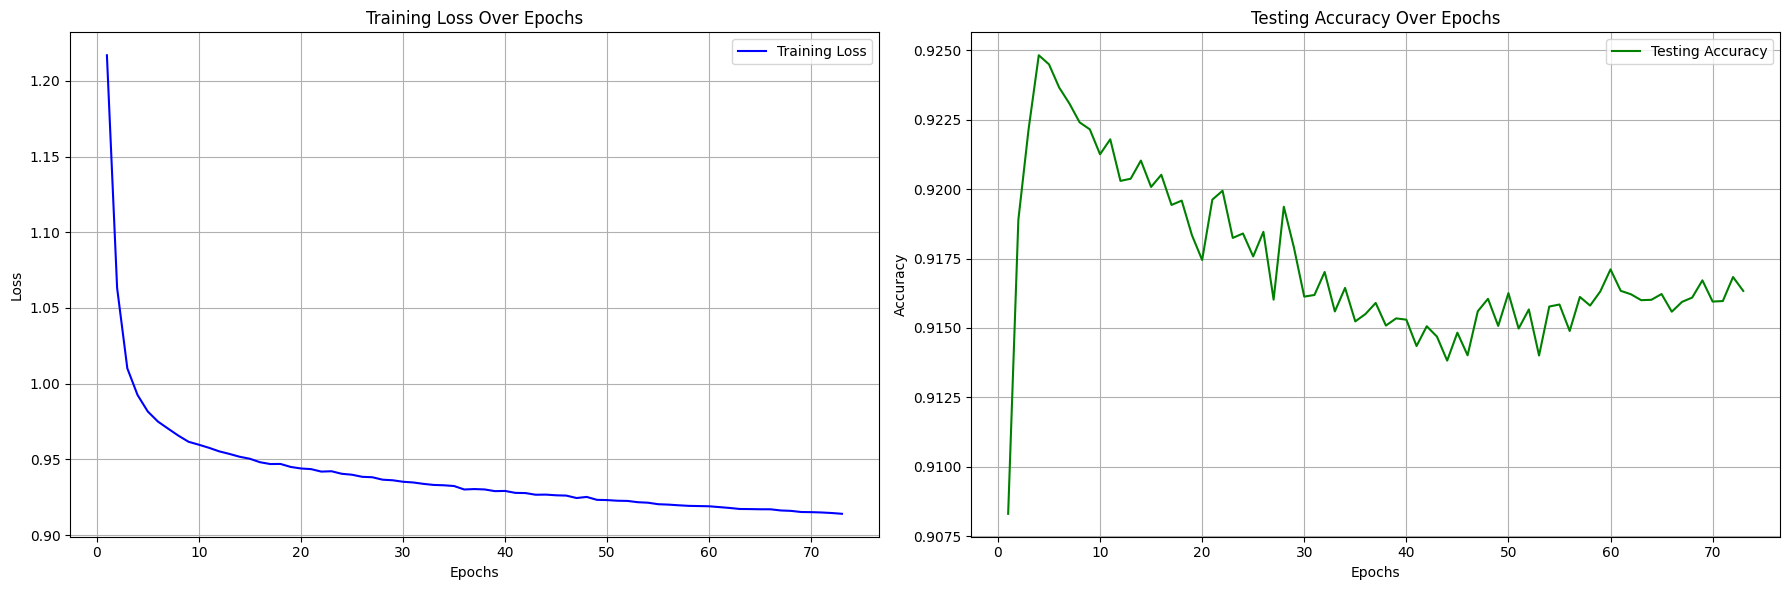

In [ ]:
# Visualization of Training Loss and Test Accuracy
plt.figure(figsize=(18, 6))

# Training Loss Plot
plt.subplot(1, 2, 1)
plt.plot(metrics["epochs"], metrics["train_loss"], label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()

# Test Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(metrics["epochs"], metrics["test_accuracy"], label="Testing Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy Over Epochs")
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

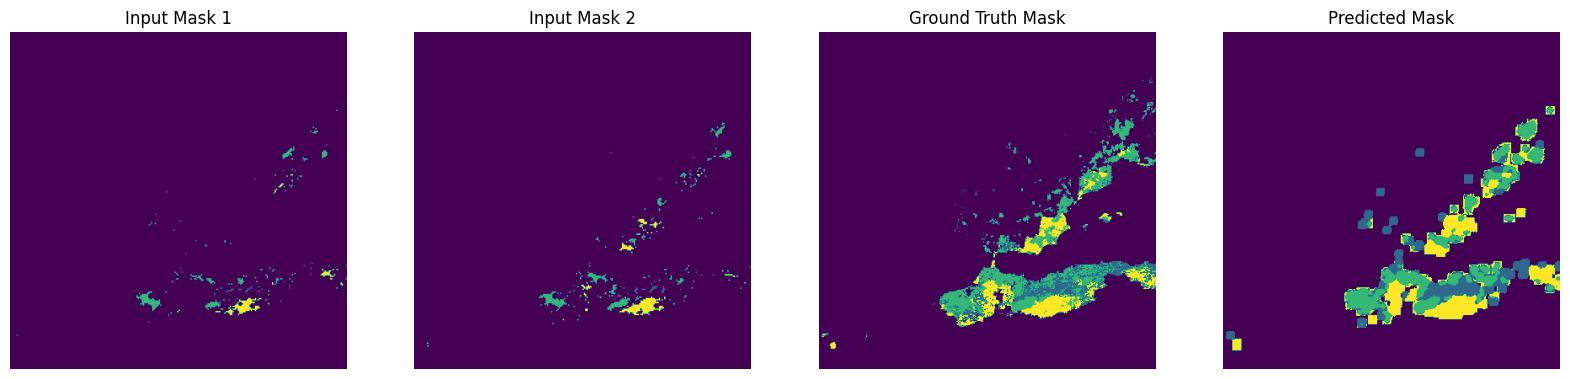

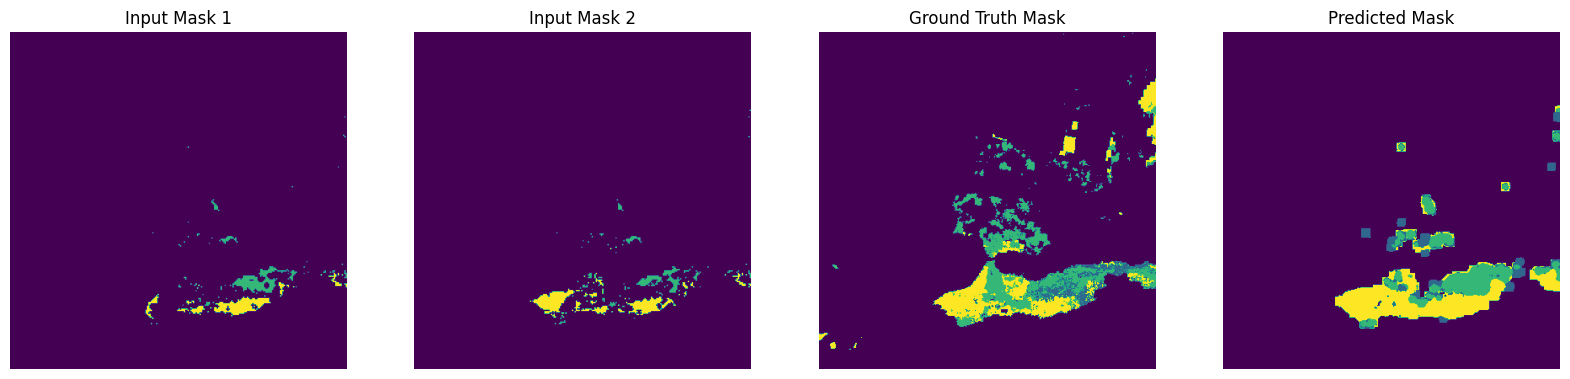

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize predictions when inputs are two masks
def visualize_predictions_with_masks(model, dataloader, num_samples=2):
    model.eval()
    inputs, ground_truths = next(iter(dataloader))  # Get a batch of data
    inputs = inputs.float().to(device)
    ground_truths = ground_truths.long().to(device)

    # Generate predictions
    with torch.no_grad():
        predictions = model(inputs)
        predicted_classes = predictions.argmax(dim=1)  # Convert to class indices

    # Move data back to CPU for visualization
    inputs = inputs.cpu().numpy()
    ground_truths = ground_truths.cpu().numpy()
    predicted_classes = predicted_classes.cpu().numpy()

    # Visualize the first `num_samples` results
    for i in range(num_samples):
        plt.figure(figsize=(20, 8))

        # Input Mask 1
        plt.subplot(1, 4, 1)
        plt.title("Input Mask 1")
        plt.imshow(inputs[i, 0].squeeze(), cmap="viridis", vmin=0, vmax=3)  # First input mask
        plt.axis("off")

        # Input Mask 2
        plt.subplot(1, 4, 2)
        plt.title("Input Mask 2")
        plt.imshow(inputs[i, 1].squeeze(),cmap="viridis", vmin=0, vmax=3) # Second input mask
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 4, 3)
        plt.title("Ground Truth Mask")
        plt.imshow(ground_truths[i],cmap="viridis", vmin=0, vmax=3)  # Use colormap for classes
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 4, 4)
        plt.title("Predicted Mask")
        plt.imshow(predicted_classes[i], cmap="viridis", vmin=0, vmax=3)
        plt.axis("off")

        plt.show()

# Visualize model predictions with input masks
visualize_predictions_with_masks(model, train_loader)

# Inference

## Load Trained Model

In [ ]:
import torch
import torch.nn as nn

class ConvLSTM(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, kernel_size=3, output_channels=4):
        super(ConvLSTM, self).__init__()

        # ConvLSTM layer for temporal processing
        self.conv_lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_channels)

        # Convolutional layers for spatial processing
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels)
        self.conv3 = nn.Conv2d(hidden_channels, output_channels, kernel_size=kernel_size, padding=1)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.3)

        # Upsampling layer to resize output to 400x400
        self.upsample = nn.Upsample(size=(400, 400), mode='bilinear', align_corners=False)

        self.relu = nn.ReLU()

    def forward(self, x):
        # x: Shape: [batch_size, seq_len, channels, height, width]
        batch_size, seq_len, channels, height, width = x.size()

        # Initialize hidden state for LSTM
        h_t = torch.zeros(batch_size, channels, height, width).to(x.device)

        # Loop through sequence
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]  # Get the t-th image in the sequence

            # Convolutional block with BatchNorm and Dropout
            x_t = self.relu(self.bn1(self.conv1(x_t)))
            x_t = self.dropout(x_t)
            x_t = self.relu(self.bn2(self.conv2(x_t)))

            # Residual connection to carry forward spatial features
            h_t = h_t + self.conv3(x_t)

        # Upsample to desired output size (400x400)
        h_t = self.upsample(h_t)

        return h_t

In [ ]:
# Load model for inference
model = ConvLSTM(input_channels=1, hidden_channels=64, kernel_size=3, output_channels=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/DL/Trained_Model/best_model_v5.pth"))

<ipython-input-135-3349d1ec77e6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/DL/Trained_Model/best_model_v5.pth

<All keys matched successfully>

## Setup and Initialization

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Pixel-to-class mapping
pixel_to_class = {0: 0, 70: 1, 162: 2, 213: 3}

# Color map for visualization
color_map = {
    0: [0, 0, 0],        # Black for class 0
    1: [255, 0, 0],      # Red for class 1
    2: [255, 255, 0],    # Yellow for class 2
    3: [255, 165, 0],    # Orange for class 3
}

# Function to map pixel values to class indices
def map_pixel_to_class(image):
    img_array = np.array(image)
    return np.vectorize(lambda x: pixel_to_class.get(x, 0))(img_array)

## Custom Dataset Class

In [ ]:
class DroughtDataset(Dataset):
    def __init__(self, sequences, folder, resize_size=(256, 256)):
        self.sequences = sequences
        self.folder = folder
        self.resize_size = resize_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Get the sequence
        input_files = self.sequences[idx]

        # Load and resize the images
        input_images = [Image.open(os.path.join(self.folder, f)).resize(self.resize_size) for f in input_files]

        # Map pixels to class labels
        input_images = [map_pixel_to_class(img) for img in input_images]

        # Add an extra dimension for the channel (1 for grayscale)
        input_images = [np.expand_dims(img, axis=0) for img in input_images]  # Shape: (1, 256, 256) for each image

        # Stack the sequence images
        input_tensor = torch.tensor(np.stack(input_images), dtype=torch.long)  # Shape: (sequence_len, 1, 256, 256)

        return input_tensor

## Creating the DataLoader

In [ ]:
# Sort the mask files
mask_files.sort(key=lambda x: (x.split('_')[0], x.split('_')[1], x.split('_')[2]))

# Initialize window size and sequences
window_size = 2
sequences = []

# Create sequences
for i in range(len(mask_files) - window_size + 1):
    input_sequence = mask_files[i:i + window_size]  # Only the input images
    sequences.append(input_sequence)

# Create the dataset and DataLoader
new_folder = "/content/SequenceFolder"
dataset = DroughtDataset(sequences, new_folder)
inference_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
sequences

[['2024_10_11.png', '2024_10_21.png']]

## Performing Inference

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Loop over the inference DataLoader
for inputs in inference_loader:
    # Move inputs to the same device as the model
    inputs = inputs.to(device).float()  # Convert inputs to float
    with torch.no_grad():  # Disable gradient calculation during inference
        predictions = model(inputs)  # Get model predictions

    # Convert logits to predicted class indices
    predictions = torch.argmax(predictions, dim=1)  # If using classification
    break  # Process one batch for testing

## Visualization of Predictions

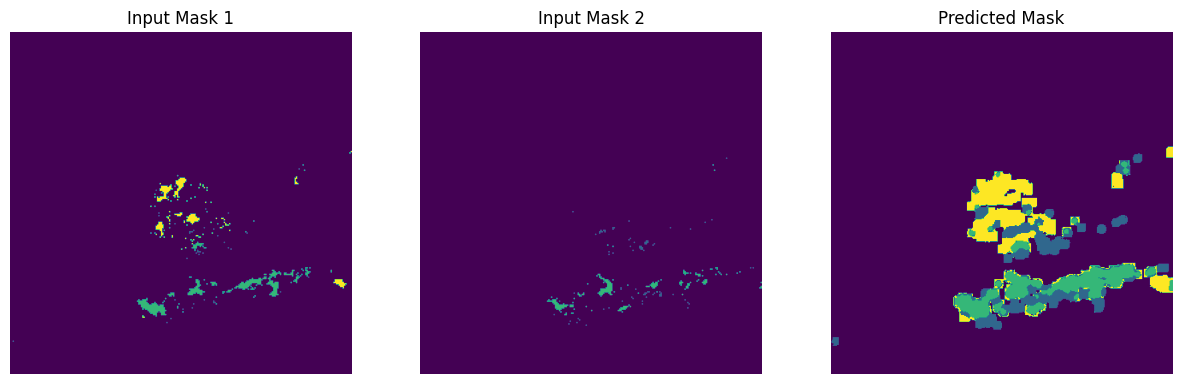

In [ ]:
# Function to visualize predictions
def visualize_predictions_with_masks_inference(model, dataloader, device, num_samples=1):
    model.eval()  # Set the model to evaluation mode

    # Get a batch of data
    inputs = next(iter(dataloader))
    inputs = inputs.float().to(device)  # Move inputs to the correct device

    # Generate predictions
    with torch.no_grad():
        predictions = model(inputs)
        predicted_classes = predictions.argmax(dim=1)  # Convert to class indices

    # Move data back to CPU for visualization
    inputs = inputs.cpu().numpy()
    predicted_classes = predicted_classes.cpu().numpy()

    # Visualize the first `num_samples` results
    for i in range(num_samples):
        plt.figure(figsize=(15, 6))

        # Input Mask 1
        plt.subplot(1, 3, 1)
        plt.title("Input Mask 1")
        plt.imshow(inputs[i, 0].squeeze(), cmap="viridis", vmin=0, vmax=3)  # First input mask
        plt.axis("off")

        # Input Mask 2
        plt.subplot(1, 3, 2)
        plt.title("Input Mask 2")
        plt.imshow(inputs[i, 1].squeeze(), cmap="viridis", vmin=0, vmax=3)  # Second input mask
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predicted_classes[i], cmap="viridis", vmin=0, vmax=3)
        plt.axis("off")

        plt.show()

# Visualize predictions for inference loader
visualize_predictions_with_masks_inference(model, inference_loader, device)

## Postprocessing and Saving the Results

In [ ]:
# Convert predictions to numpy array
predictions_np = predictions.squeeze(0).cpu().numpy()  # Shape: [400, 400]

# Initialize an empty array for the colored segmented image
segmented_image = np.zeros((*predictions_np.shape, 3), dtype=np.uint8)

# Apply the color mapping
for class_idx, color in color_map.items():
    segmented_image[predictions_np == class_idx] = color

# Convert the segmented image to a PIL image and save/display
result_image = Image.fromarray(segmented_image)
result_image.save("segmented_output.png")
result_image.show()  # Display the result

## Overlay Mask on Base Image


In [ ]:
# Paths to base image
base_image_path = "/content/drive/MyDrive/DL/Dataset/BaseMap_Morocco.png"

# Convert predictions to numpy array
predictions_np = predictions.squeeze(0).cpu().numpy()  # Shape: [400, 400]

# Map indices to colors for visualization
color_map = {
    0: [0, 0, 0],        # Black for class 0
    1: [255, 0, 0],      # Red for class 1
    2: [255, 255, 0],    # Yellow for class 2
    3: [255, 165, 0],    # Orange for class 3
}

# Initialize an empty array for the colored segmented image
segmented_image = np.zeros((*predictions_np.shape, 3), dtype=np.uint8)

# Apply the color mapping
for class_idx, color in color_map.items():
    segmented_image[predictions_np == class_idx] = color

# Convert the segmented image to a PIL image
segmented_mask = Image.fromarray(segmented_image, mode="RGB").convert("RGBA")

# Remove black background by setting it as transparent
data = segmented_mask.getdata()
new_data = []
for item in data:
    # Check if the pixel is black (0, 0, 0)
    if item[:3] == (0, 0, 0):  # Ignore alpha channel
        new_data.append((0, 0, 0, 0))  # Fully transparent
    else:
        new_data.append(item)  # Keep original color

# Update the mask with transparency
segmented_mask.putdata(new_data)

# Load the base image
base_image = Image.open(base_image_path).convert("RGBA")  # Ensure RGBA for transparency

# Resize mask to match base image size (if needed)
segmented_mask = segmented_mask.resize(base_image.size, resample=Image.NEAREST)

# Overlay the mask on the base image
overlayed_image = Image.alpha_composite(base_image, segmented_mask)

# Save and display the result
output_path = "overlayed_map_no_black__22.png"
overlayed_image.save(output_path)
overlayed_image.show()

print(f"Overlayed map saved at {output_path}")

Overlayed map saved at overlayed_map_no_black__22.png
